In [26]:
import os
import numpy as np
import cv2
import matplotlib.pylab as plt
# from bagoftools.logger import Logger
# from utils import save_imgs
import imgSlicing
import torch

from models.cae_32x32x32_zero_pad_bin import CAE

In [18]:
def imgTransformer(inputFolder,name):
    print(name)
    image = cv2.imread(os.path.join(inputFolder,name))
    image = np.array(image)
    pad = ((24, 24), (0, 0), (0, 0))

    img = np.pad(image, pad, mode="edge") / 255.0
    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img).float()
    print(img.shape)
    patches = np.reshape(img, (3, 6, 128, 10, 128))
    patches = np.transpose(patches, (0, 1, 3, 2, 4))
    
    return img,patches,name
    

def imgPreprocess(inputFolder):
    print(f'The input folder specified is {str(inputFolder)}')
    patch = torch.empty(len(os.listdir(inputFolder)),3,6,10,128,128)
    img = torch.empty(len(os.listdir(inputFolder)),3,768,1280)
    name = []
    for idx,images in enumerate(os.listdir(inputFolder)):
        img[idx]=imgTransformer(inputFolder,images)[0]
        patch[idx]=imgTransformer(inputFolder,images)[1]
        name.append(imgTransformer(inputFolder,images)[2])
    # img = np.array(img)
    # patch = np.array(patch)
    
    return img,patch,name
    
def imgEncoding(name,patches,checkpoint,interFolder):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    encoder = CAE()
    encoder.load_state_dict(torch.load(checkpoint))
    encoder.eval()
    
    encoder.to(device)
    
    for idx,patcher in enumerate(patches):
        out=[]
        name[idx] = name[idx].split('.')[0]
        # patch = torch.tensor(patcher).to(device)
        print('the patch shape is:',patcher.shape)
        out = torch.zeros(6,10, 32, 32, 32)
        for i in range(6):
            for j in range(10):
                x = patcher[None,:, i, j, :, :]
                y = encoder(x)
                # print('The shape is y',y.shape)
                out[i,j]=y.data
        # print('the output final shapoe is:',out.shape)
        # out = np.array(out)
        torch.save(out,os.path.join(interFolder,str(name[idx])+'.pt'))
        
    # logger.info('The images are encoded and saved') 
    
    return encoder

def imgDetransformation(img):
    out = np.transpose(img, (0, 3, 1, 4, 2))
    out = np.reshape(img, (768, 1280, 3))
    out = np.transpose(out, (2, 0, 1))
    return out

def imgDeymstify(inFolder,outFolder,model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu' 
    torch.cuda.empty_cache()
    for encoded in os.listdir(inFolder):
        imgEncoded = torch.load(os.path.join(inFolder,encoded))
        imgEncoded = torch.tensor(imgEncoded).to(device)
        # imgEncoded = imgEncoded.squeeze(1)
        out = torch.zeros(6,10, 3, 128, 128)
        for i in range(6):
            for j in range(10):
                result = model.decode(imgEncoded[i][j].unsqueeze(0))
                out[i,j] = result.data
        print('the outut is',out.shape)
        out = imgDetransformation(out)
        print(out.shape)
        save_imgs(
            imgs=out.unsqueeze(0),
            to_size=(3, 768,1280),
            name="hello.png",
        )
        # plt.imshow(out)
        # plt.show()
        
    

# if __name__ == '__main__':
#     outputFolder = r'../output'
#     inputFolder  = r'../input'
#     interFolder  = r'../intermediate'
    
#     os.makedirs(outputFolder, exist_ok=True)
#     os.makedirs(inputFolder, exist_ok=True)
#     os.makedirs(interFolder, exist_ok=True)
    
#     images,patches,names = imgPreprocess(inputFolder)
#     print(patches.shape)
#     model = imgEncoding(names,patches,r'../checkpoint/model_final.state',interFolder)
#     imgDeymstify(interFolder,outputFolder,model)
    
    

In [19]:
outputFolder = r'../output'
inputFolder  = r'../input'
interFolder  = r'../intermediate'
os.makedirs(outputFolder, exist_ok=True)
os.makedirs(inputFolder, exist_ok=True)
os.makedirs(interFolder, exist_ok=True)

In [21]:
patch.shape

torch.Size([8, 3, 6, 10, 128, 128])

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = CAE()
encoder.load_state_dict(torch.load(r'../checkpoint/model_final.state'))
encoder.eval()

encoder.to(device)

for idx,patcher in enumerate(patch):
    # print(idx)
    name[idx] = name[idx].split('.')[0]
    # patch = torch.tensor(patcher).to(device)
    print('the patch shape is:',patcher.shape)
    print(name[idx])
    out = torch.zeros(6,10, 32, 32, 32)
    for i in range(6):
        for j in range(10):
            x = patcher[None,:, i, j, :, :].to(device)
            y = encoder(x)
            # print('The shape is y',y.shape)
            out[i,j]=y.data
    # print('the output final shapoe is:',out.shape)
    # out = np.array(out)
    torch.save(out,os.path.join(interFolder,str(name[idx])+'.pt'))

the patch shape is: torch.Size([3, 6, 10, 128, 128])
frame_18
the patch shape is: torch.Size([3, 6, 10, 128, 128])
frame_19
the patch shape is: torch.Size([3, 6, 10, 128, 128])
frame_20
the patch shape is: torch.Size([3, 6, 10, 128, 128])
frame_21
the patch shape is: torch.Size([3, 6, 10, 128, 128])
frame_22
the patch shape is: torch.Size([3, 6, 10, 128, 128])
frame_23
the patch shape is: torch.Size([3, 6, 10, 128, 128])
frame_24
the patch shape is: torch.Size([3, 6, 10, 128, 128])
frame_6


In [50]:
patcher[None,:, i, j, :, :].shape
y.shape
out.shape

torch.Size([6, 10, 32, 32, 32])

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
torch.cuda.empty_cache()
imgEncoded = torch.load(os.path.join(interFolder,'frame_6.pt'))
imgEncoded.shape

torch.Size([6, 10, 32, 32, 32])

In [38]:
out.shape

torch.Size([6, 10, 32, 32, 32])

In [39]:
imgEncoded[1,2,:,:,:].unsqueeze(0).shape

torch.Size([1, 32, 32, 32])

In [42]:
imgEncoded=imgEncoded.to(device)
# imgEncoded = imgEncoded.squeeze(1)
out1 = torch.zeros(6,10, 3, 128, 128)
for i in range(6):
    for j in range(10):
        result = encoder.decode(imgEncoded[i,j,:,:,:].unsqueeze(0))
        out1[i,j] = result.data
print('the outut is',out1.shape)
# out = imgDetransformation(out)
# print(out.shape)
# save_imgs(
#     imgs=out.unsqueeze(0),
#     to_size=(3, 768,1280),
#     name="hello.png",
# )

the outut is torch.Size([6, 10, 3, 128, 128])


In [44]:
foo = np.transpose(out1,(0,3,1,4,2))
foo = np.reshape(foo,(768,1280,3))
foo.shape

torch.Size([768, 1280, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


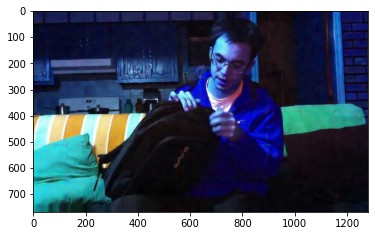

In [45]:
foo1 = foo.detach().cpu().numpy()
plt.imshow(foo1)

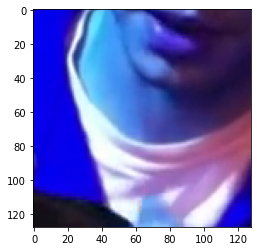

In [9]:
foo = patch.permute(1,2,3,4,0)
plt.imshow(foo[2,5,:,:,:])

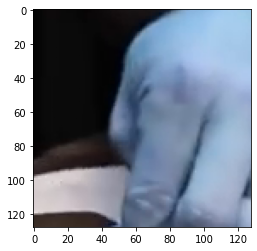

In [24]:
foo = patch[0].permute(1,2,3,4,0)
plt.imshow(foo[2,5,:,:,:])

In [13]:
print(name)
image = cv2.imread(os.path.join(inputFolder,name))
image = np.array(image)
pad = ((24, 24), (0, 0), (0, 0))

img = np.pad(image, pad, mode="edge") / 255.0
img = np.transpose(img, (2, 0, 1))
img = torch.from_numpy(img).float()
print(img.shape)
patches = np.reshape(img, (3, 6, 128, 10, 128))
patches = np.transpose(patches, (0, 1, 3, 2, 4))

frame_6.bmp
torch.Size([3, 768, 1280])


(<matplotlib.image.AxesImage at 0x278a66bcca0>, torch.Size([3, 768, 1280]))

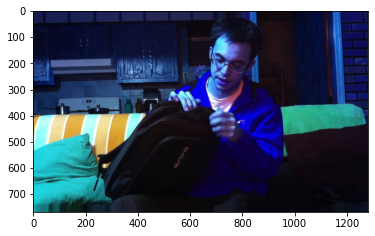

In [16]:
plt.imshow(np.transpose(img,(1,2,0))),img.shape

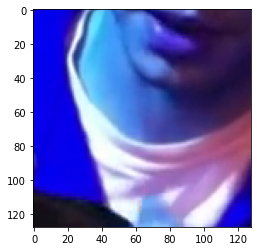

In [19]:
# patches = img.reshape(6,128,10,128,3)
# patches = patches.transpose(0,2,1,3,4)
foo = np.transpose(patches,(1,2,3,4,0))
plt.imshow(foo[2,5,:,:,:])

In [20]:
patches.shape,foo.shape

(torch.Size([3, 6, 10, 128, 128]), torch.Size([6, 10, 128, 128, 3]))

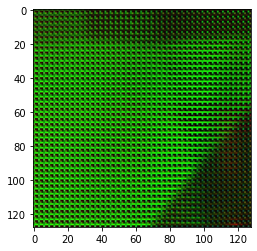

In [58]:
plt.imshow(patches[:,3,9,:,:].transpose(1,2,0))

(<matplotlib.image.AxesImage at 0x29767332220>, (768, 1280, 3))

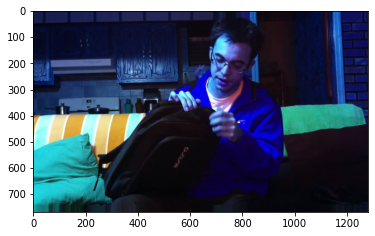

In [10]:
plt.imshow(img),img.shape

(<matplotlib.image.AxesImage at 0x297672cc9d0>, (720, 1280, 3))

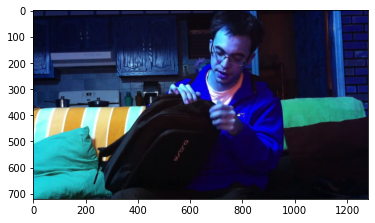

In [9]:
plt.imshow(image),image.shape

In [19]:
plt.imshow(patches[,2,:,:,:]),pacthes.shape

torch.Size([3, 6, 10, 128, 128])

In [35]:
print(f'The input folder specified is {str(inputFolder)}')
img,patch,name = [],[],[]
for idx,images in enumerate(os.listdir(inputFolder)):
    img.append(imgTransformer(inputFolder,images)[0].numpy())
    doo[idx]=imgTransformer(inputFolder,images)[1]
    name.append(imgTransformer(inputFolder,images)[2])
img = np.array(img)
patch = np.array(patch)

The input folder specified is ../input
frame_18.bmp
torch.Size([3, 768, 1280])
frame_18.bmp
torch.Size([3, 768, 1280])
frame_18.bmp
torch.Size([3, 768, 1280])
frame_19.bmp
torch.Size([3, 768, 1280])
frame_19.bmp
torch.Size([3, 768, 1280])
frame_19.bmp
torch.Size([3, 768, 1280])
frame_20.bmp
torch.Size([3, 768, 1280])
frame_20.bmp
torch.Size([3, 768, 1280])
frame_20.bmp
torch.Size([3, 768, 1280])
frame_21.bmp
torch.Size([3, 768, 1280])
frame_21.bmp
torch.Size([3, 768, 1280])
frame_21.bmp
torch.Size([3, 768, 1280])
frame_22.bmp
torch.Size([3, 768, 1280])
frame_22.bmp
torch.Size([3, 768, 1280])
frame_22.bmp
torch.Size([3, 768, 1280])
frame_23.bmp
torch.Size([3, 768, 1280])
frame_23.bmp
torch.Size([3, 768, 1280])
frame_23.bmp
torch.Size([3, 768, 1280])
frame_24.bmp
torch.Size([3, 768, 1280])
frame_24.bmp
torch.Size([3, 768, 1280])
frame_24.bmp
torch.Size([3, 768, 1280])
frame_6.bmp
torch.Size([3, 768, 1280])
frame_6.bmp
torch.Size([3, 768, 1280])
frame_6.bmp
torch.Size([3, 768, 1280])


In [23]:
patch.shape

(8, 3, 6, 10, 128, 128)

In [37]:
foo = doo.reshape(8,6,10,128,128,3)

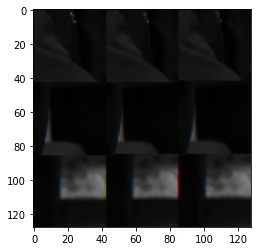

In [38]:
plt.imshow(foo[0,2,7,:,:,:])

In [33]:
doo = torch.empty(8,3,6,10,128,128)

In [36]:
doo.shape

torch.Size([8, 3, 6, 10, 128, 128])

In [62]:
!pip install image_slicer

In [8]:
name = 'frame_6.bmp'
print(name)
image = cv2.imread(os.path.join(inputFolder,name))

frame_6.bmp


In [9]:
image = np.array(image)
pad = ((24, 24), (0, 0), (0, 0))

img = np.pad(image, pad, mode="edge") / 255.0

In [14]:
img.shape

(768, 1280, 3)

In [16]:
x = imgSlicing.slice(img, 60,save=False)

TypeError: cannot unpack non-iterable int object

In [27]:
type(x[0].image)

PIL.Image.Image

In [28]:
foo = np.array(x[0].image)

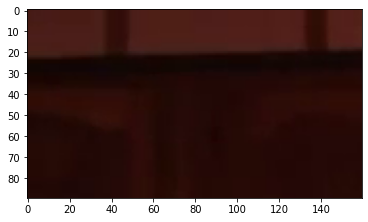

In [29]:
plt.imshow(foo)

In [30]:
foo.shape

(90, 160, 3)

torch.Size([6, 10, 32, 32, 32])
the name is frame_18.pt and the type is <class 'str'> and the output is initialized
the outut is torch.Size([6, 10, 3, 128, 128])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([6, 10, 32, 32, 32])
the name is frame_19.pt and the type is <class 'str'> and the output is initialized
the outut is torch.Size([6, 10, 3, 128, 128])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([6, 10, 32, 32, 32])
the name is frame_20.pt and the type is <class 'str'> and the output is initialized
the outut is torch.Size([6, 10, 3, 128, 128])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([6, 10, 32, 32, 32])
the name is frame_21.pt and the type is <c

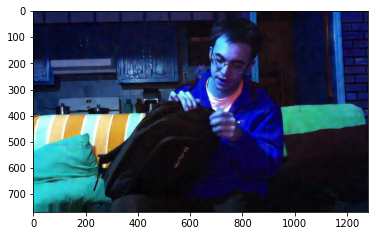

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CAE()
model.load_state_dict(torch.load(r'../checkpoint/model_final.state'))
model.eval()

model.to(device)
torch.cuda.empty_cache()

for encoded in os.listdir(interFolder):
    imgEncoded = torch.load(os.path.join(interFolder,encoded))
    imgEncoded = imgEncoded.to(device)
    print(imgEncoded.shape)
    # imgEncoded = imgEncoded.squeeze(2)
    print(f'the name is {encoded} and the type is {type(encoded)} and the output is initialized')
    out = torch.zeros(6,10, 3, 128, 128)
    for i in range(6):
        for j in range(10):
            result = model.decode(imgEncoded[i,j,:,:,:].unsqueeze(0))
            # print('imgEncoded',imgEncoded[i,j,:,:,:].unsqueeze(0).shape)
            # print('resukt',result.shape)
            out[i,j] = result.data
    print('the outut is',out.shape)
    foo = np.transpose(out,(0,3,1,4,2))
    foo = np.reshape(foo,(768,1280,3))
    plt.imshow(foo)
    plt.imshow()
    del(out)
    print('===============================================================================================')
    # out = imgDetransformation(out)
    # print(out.shape)
    # plt.imshow(out)
    # plt.show()
    # break

In [53]:
imgEncoded.shape

torch.Size([6, 10, 32, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


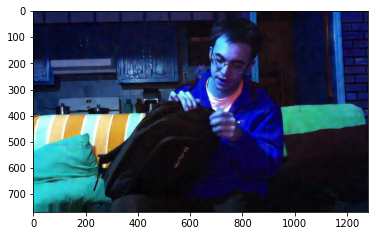

In [56]:
foo = np.transpose(out,(0,3,1,4,2))
foo = np.reshape(foo,(768,1280,3))
plt.imshow(foo)